# 1) Prepare X_train, X_val, y_train, y_val

In [1]:
import LoadAndPreprocessDataset

In [2]:
#Load filenames
train,val,test = LoadAndPreprocessDataset.loadDatasetFilenames()

#Load TRAIN files
X,y_train=LoadAndPreprocessDataset.loadBatch(train,batch_size=30000)
#Preprocess TRAIN
#X_train=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_train=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
X_train=LoadAndPreprocessDataset.melspect(X)
#X_train=X #No preprocessing
#Release memory
del(X)

#Load VAL files
X,y_val=LoadAndPreprocessDataset.loadBatch(val,batch_size=3000)
#Preprocess VAL
#X_val=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_val=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
X_val=LoadAndPreprocessDataset.melspect(X)
#X_val=X #No preprocessing
#Release memory
del(X)

print(X_train.shape,X_val.shape)


# NORMALIZATION
### NO normalization seems better
#from sklearn.preprocessing import normalize
#from sklearn.preprocessing import MinMaxScaler
#scaler = MinMaxScaler(feature_range=(-1,1)) # Gives huge bias
#for i in range(len(X_train)):
    #X_train[i]=normalize(X_train[i], axis=0, norm='max') #normalize each feature of the example
    #X_train[i]=(X_train[i] - X_train[i].min(0)) / X_train[i].ptp(0) # HUGE BIAS
    #X_train[i]=scaler.fit_transform(X_train[i]) # HUGE BIAS
#for i in range(len(X_val)):
    #X_val[i]=normalize(X_val[i], axis=0, norm='max') #normalize each feature of the example
    #X_val[i]=(X_val[i] - X_val[i].min(0)) / X_val[i].ptp(0) #HUGE BIAS
    #X_val[i]=scaler.fit_transform(X_val[i])  # HUGE BIAS


#ADD extra dimension for CNN
import numpy as np
X_train = X_train[..., np.newaxis]
X_val = X_val[..., np.newaxis]
print(X_train.shape,X_val.shape)


print('X_train uses',X_train.shape[0],"of",len(train),"files")
print('X_val uses',X_val.shape[0],"of",len(val),"files")

(30000, 80, 126) (3000, 80, 126)
(30000, 80, 126, 1) (3000, 80, 126, 1)
X_train uses 30000 of 30769 files
X_val uses 3000 of 3703 files


(30000, 80, 126, 1)
(30000,)
(3000, 80, 126, 1)
(3000,)


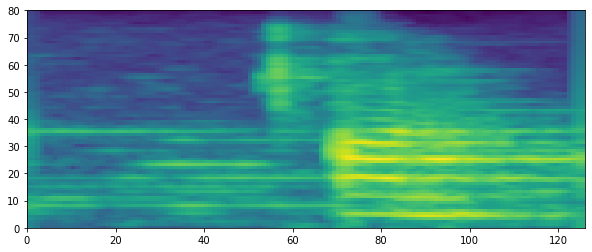

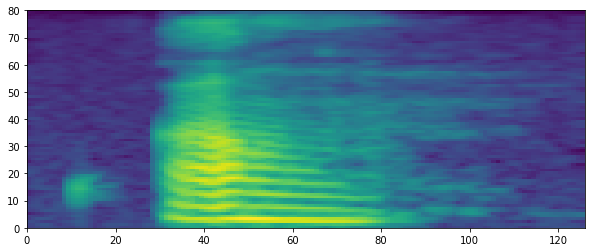

-80.0
9.5367431640625e-07


'for i in range(len(X_train[1])):\n    print(i,np.min(X_train[1,i]),np.max(X_train[1,i]))\nprint(X_train[1].shape)'

In [3]:
# Look at some data

print(X_train.shape)
print(y_train.shape)
print(X_val.shape)
print(y_val.shape)

import matplotlib.pyplot as plt
plt.figure(figsize=(10, 4))
plt.pcolormesh(X_train[0,:,:,0])
plt.show()

plt.figure(figsize=(10, 4))
plt.pcolormesh(X_val[0,:,:,0])
plt.show()

import numpy as np
print(np.min(X_train))
print(np.max(X_train))

'''for i in range(len(X_train[1])):
    print(i,np.min(X_train[1,i]),np.max(X_train[1,i]))
print(X_train[1].shape)'''

----------------------------------------------------

# 2) Model


## Define NN

In [4]:
import Models

In [5]:
categories=['yes','no','up','down','left','right','on','off','stop','go']
nCategories=len(categories)


import datetime
modelName="DSConvModel"
save_name=datetime.datetime.now().strftime("%Y-%m-%d_%H-%M")+"_"+modelName


model = Models.DSConvModel(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)
'''model = Models.DSConvModelSmall(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)
model = Models.DSConvModelMedium(nCategories,
                        inputShape=X_train.shape[1:],
                        name=modelName)'''

model.compile(optimizer='nadam',
              loss=['sparse_categorical_crossentropy'],
              metrics=['sparse_categorical_accuracy'])

model.summary()

Model: "DSConvModel"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 80, 126, 1)]      0         
_________________________________________________________________
conv2d (Conv2D)              (None, 80, 63, 276)       11316     
_________________________________________________________________
batch_normalization (BatchNo (None, 80, 63, 276)       1104      
_________________________________________________________________
depthwise_conv2d (DepthwiseC (None, 39, 31, 276)       2760      
_________________________________________________________________
batch_normalization_1 (Batch (None, 39, 31, 276)       1104      
_________________________________________________________________
activation (Activation)      (None, 39, 31, 276)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 39, 31, 276)       

## Train NN

In [6]:
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint, LearningRateScheduler, TensorBoard
import math


log_dir = "logs\\"+save_name

def step_decay(epoch):
    initial_lrate = 0.001
    drop = 0.4
    epochs_drop = 15.0
    lrate = initial_lrate * math.pow(drop, math.floor((1+epoch)/epochs_drop))
    
    if (lrate < 4e-5):
        lrate = 4e-5
      
    print('Changing learning rate to {}'.format(lrate))
    return lrate
lrate = LearningRateScheduler(step_decay)

def performance_scheduling(epoch):
    #.....
    return lrate

my_callbacks = [
    EarlyStopping(monitor='val_sparse_categorical_accuracy',
                  patience=25,
                  verbose=1,
                  restore_best_weights=True),
    ModelCheckpoint('models/'+save_name+'.h5',
                    monitor='val_sparse_categorical_accuracy',
                    verbose=1,
                    save_best_only=True),
    TensorBoard(log_dir=log_dir,histogram_freq=1)]
    #lrate]


In [7]:
#Train
results = model.fit(x=X_train,
                    y=y_train,
                    validation_data=(X_val,y_val),
                    batch_size=32, # usually between 10 and 32
                    epochs=150,
                    callbacks=my_callbacks,
                    verbose=1)

#model.save('models/'+modelName+'.h5')

Train on 30000 samples, validate on 3000 samples
Epoch 1/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.6499 - sparse_categorical_accuracy: 0.8132  - ETA: 2:55 - loss: 1.9626 - sparse_categorical_a - ETA: 2:13 - loss: 1.3059 - sparse_categorical_accura - ETA: 2:10 - loss: 1.2786 - sparse_c - ETA: 2:04 - loss: 1.2122 - sparse_categorical_accuracy: 0. - ETA: 2:03 - loss: 1.2023 - sparse_categorical - ETA: 1:59 - loss: 1.1685 - sparse_categorical_accuracy: - ETA: 1:57 - loss: 1.1541 - sparse_categorical_ac - ETA: 1:54 - loss: 1.1270 - sparse_categorical_accurac - ETA: 1:52 - loss: 1 - ETA: 1:42 - loss: 1.0423 -  - ETA: 1:35 - loss: 0.9 - ETA: 1:26 - loss: 0.9406 - sparse_categoric - ETA: 1:22 - loss: 0.9177 - s - ETA: 1:14 - loss: 0.8828 - sp - ETA: 1:07 - loss: 0.8518 - sparse_categorical_ac - ETA: 1:04 - - ETA: 50s - loss: 0.7865 - sparse_categorical_accuracy: 0. - ETA: 49s - loss: 0.7852 - sparse_categorica - ETA: 47s - loss: 0.7785 - sparse_categorical_accuracy: 

Epoch 11/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.0405 - sparse_categorical_accuracy: 0.9867- ETA: 6s - loss: 0.0405 - spars - ETA: 0s - loss: 0.0405 - sparse_categorical_accuracy: 0.986
Epoch 00011: val_sparse_categorical_accuracy did not improve from 0.94400
30000/30000 [==============================] - 191s 6ms/sample - loss: 0.0405 - sparse_categorical_accuracy: 0.9867 - val_loss: 0.2754 - val_sparse_categorical_accuracy: 0.9413
Epoch 12/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.0361 - sparse_categorical_accuracy: 0.9882
Epoch 00012: val_sparse_categorical_accuracy did not improve from 0.94400
30000/30000 [==============================] - 186s 6ms/sample - loss: 0.0361 - sparse_categorical_accuracy: 0.9882 - val_loss: 0.2630 - val_sparse_categorical_accuracy: 0.9440
Epoch 13/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.0327 - sparse_categorical_accuracy: 0.9890
Epoch 00013: val_sparse_categorical_accur

29984/30000 [============================>.] - ETA: 0s - loss: 0.0188 - sparse_categorical_accuracy: 0.9942  - ETA: 2:55 - loss: 0.0086 - sparse_categorical_accuracy: 0.99 - - ETA: 2:43 - loss: 0.0120 - sparse_categori - ETA: 2:39 - loss: 0.0119 - sparse_categorical - ETA: 2:36 - loss: 0.0106 - sparse_categorical_ - ETA: 2:33 - loss: 0.0128 - sparse_categorical_accura - ETA: 2:31 - loss: 0.0133 - sparse_categorical_accuracy: 0. - ETA: 2:30 - loss: 0.0131 - sparse_categor - ETA: 2:26 - loss: 0.0129 - sparse_categorical_accura - ETA: 2:24 - loss: 0.0132 - sparse_categ - ETA: 2:20 - - ETA: 2:1 - ETA: 2:00 - loss: 0.0229 - sparse_categorical_accuracy: 0 - ETA: 1:59 - loss: 0.0227 - sparse_categorical_accuracy: 0 - ETA: 1:58 - loss: 0.0241 - sparse_categorical_accuracy - ETA: 1:57 - loss: 0.0238 - sparse_catego - ETA: 1:52 - loss: 0.0240 - sparse_categorical_accura - ETA: 1:50 - loss: 0.0237 - sparse_categorical - ETA: 1:47 - loss: 0.0233 - sparse_ - ETA: 1:42 - loss: 0.0241 - sparse_catego

29984/30000 [============================>.] - ETA: 0s - loss: 0.0096 - sparse_categorical_accuracy: 0.9973   - ETA: 2:56 - loss: 0.0034 - sparse_categorical_accurac - ETA: 2:55 - loss: 0.0057 - ETA: 2:47 - loss: 0.0048 - sparse_categorical - ETA - ETA: 2:33 - loss: 0.0047 - - ETA: 2:26 - loss: 0.0045 - sparse_cat - ETA: 2:21 - loss: 0.0045 - sparse_categorical_acc - ETA: 2:18 - loss: 0.0050 - sparse_categorical_ - ETA: 2:15 - loss: 0.0049 - sparse_categorical_a - ETA: 2:13 - loss: 0.0047 - sparse_catego - ETA: 2:08 - loss: 0.0052 - sparse_categorica - ETA - ETA: 4s - loss: 0.0095 - sparse_cat
Epoch 00026: val_sparse_categorical_accuracy did not improve from 0.94967
30000/30000 [==============================] - 186s 6ms/sample - loss: 0.0096 - sparse_categorical_accuracy: 0.9973 - val_loss: 0.3643 - val_sparse_categorical_accuracy: 0.9437
Epoch 27/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.0125 - sparse_categorical_accuracy: 0.9964  ETA: 36s - loss - ETA: 19s

29984/30000 [============================>.] - ETA: 0s - loss: 0.0106 - sparse_categorical_accuracy: 0.9967  - ETA:  - ETA: 2:45 - loss: 0.0140 - sparse_categorical_accuracy - ETA: 2:44 - loss: 0.0143 - sparse_categorica - ETA: 2:40 - loss: 0.0161 - sparse_categorical_a - ETA: 2:38 - loss: 0.01 - ETA: 2:30 -  - ETA: 2:20 - loss: 0.0155 - sparse_categorical_accuracy: 0 - ETA: 2:20 - loss: 0.0152 - sparse_categorical_accur - ETA: 2:17 - loss: 0.0146 - sparse_categorical_ - ETA: 2:14 - loss: 0.0141 - sparse_categorical_accurac - ETA: 2:13 - loss: 0.0142 - sparse_categorical_a - ETA: 2:10 - loss: 0.0138 - sparse_categorical_accuracy: 0.996 - ETA: 2:10 - loss: 0.0138 - spars - ETA: 12s - loss: 0 - ETA: 6s - loss: 0.0108 - sparse_categorical_accuracy: 0. - ETA: 5s - loss: 0.0108 - sparse_categorical_a - ETA: 2s - loss: 0.0107 - sparse_categorical_acc - ETA: 0s - loss: 0.0106 - sparse_categorical_accuracy: 0.99
Epoch 00031: val_sparse_categorical_accuracy did not improve from 0.95433
30000/30

29984/30000 [============================>.] - ETA: 0s - loss: 0.0108 - sparse_categorical_accuracy: 0.9970  - ETA: 2:26 - loss: 0.0127 - sparse_categorica - ETA: 2:23 - loss: 0.0123 - sparse_ca - ETA: 2:18 - loss: 0.0133 - sparse_categorical_accuracy: 0.99 - ETA: 2:18 - loss: 0.0132 - sparse_categoric - ETA: 1:49 - loss: 0.0117 - sparse_categorical_accuracy: 0 - ETA: 1:48 - loss: 0.0115 - sparse_categorical_accuracy: 0 - ETA: 1:47 - loss: 0.0114 - sparse_categorical_accura - ETA: 1:45 - loss: 0.0113 - sparse_categorical_accuracy:  - ETA: 1:44 - loss: 0.0113 - sparse_c - ETA: 1:39 - loss: 0.0116 - sparse_categorical_accuracy: 0.9 - ETA: 1:38 - loss: 0.0115 - sparse_categorical_accuracy: 0.997 - ETA: 1:38 - loss: 0.0115 - sparse_categorical_accuracy:  - ETA: 1:37 - loss: 0.0114 - sparse_ - E - ETA: 1:20 - loss: 0.0116 - sparse_categorica - ETA: 1:17 - los - ETA: 27s - loss: 0.0109 - sparse_categorical_accuracy:  - ETA: 27s - loss: 0.0109 - sparse_categorica - ETA: 25s - loss: 0.0109 - s

29984/30000 [============================>.] - ETA: 0s - loss: 0.0122 - sparse_categorical_accuracy: 0.9966  - ETA: 2:55 - loss: 0.0065 - sparse_categorical_accuracy: 0.99 - ETA: 2:54 - loss: 0.0058 - sparse_categorical - ETA: 2:51 - loss: 0.0119 - sparse_categorical_accurac - ETA: 2:50 - loss: 0.0097 - sparse_categorical_accuracy: 0. - ETA: 2:49 - loss: 0.0089 - sparse_categorical_accuracy: 0.99 - ETA: 2:48 - loss: 0.0086 - sparse_categorical_accuracy: 0 - ETA: 2:47 - loss: 0.0079 - sparse_categorical_accuracy: 0 - ETA: 2:46 - loss: 0.0075 - sparse_categorical_accuracy: 0 - ETA: 2:45 - loss: 0.0074 - sparse_categorical_accuracy: 0.99 - ETA: 2:45 - loss: 0.0072 - sparse_categorical_accuracy - ETA: 2:43 - loss: 0.0065 - sparse_categorical_accur - ETA: 2:41 - loss: 0.0078 - sparse_categorical_ - ETA: 2:38 - loss: 0.0070 - sparse_categorical_accuracy - ETA: 2:37 - loss: 0.0065 - sparse_categorical_accuracy: 0.9 - ETA: 2:36 - loss: 0.0064 - sparse_categorical_accuracy: 0.998 - ETA: 2:36 - 

29984/30000 [============================>.] - ETA: 0s - loss: 0.0088 - sparse_categorical_accuracy: 0.9976      - ETA: 2:58 - loss: 5.3553e-05 - sparse_categorical_accuracy: 1.000 - ETA: 2:57 - loss: 4.6572e-05 - sparse_categorical_accurac - ETA: 2:55 - loss: 1.9166e-04 - sparse_categorical_accuracy: 1.000 - ETA: 2:55 - loss: 2.2275e-04 - sparse_categor - ETA: 2:51 - loss: 2.0945e-04 - sparse_ - ETA: 2:45 - loss: 6.3630e-04 - sparse_categorical_accuracy: - ETA: 2:44 - loss: 5.8254e-04 - sparse_categorical_accuracy: 1.000 - ETA: 2:43 - los - ETA: 2:34 - loss: 5.0454e-04 - sparse_categorical_accuracy: 1.0 - ETA: 2:33 - loss: 5.0266e-04 - sparse_categorical_accuracy: - ETA: 2:32 - loss: 4.7759e-04 - sparse_categorical_accuracy: 1.00 - ETA: 2:31 - loss: 4.8610e-04 - sparse_categorical_accuracy: 1 - ETA: 2:30 - loss: 5.2606e-04 - sparse_categorical_accura - ETA: 2:29 - loss: 5.0209e-04 - sparse_categorical_accuracy: 1.0 - ETA: 2:28 - loss: 4.9249e-04 - sparse_c - ETA: 2:23 - loss: 5.0168e-

29984/30000 [============================>.] - ETA: 0s - loss: 0.0076 - sparse_categorical_accuracy: 0.9978    - ETA: 2:56 - loss: 0.0365 - sparse_categorical_accuracy - ETA: 2:54 - loss: 0.0149 - sparse_categorical_accuracy: 0.997 - ETA: 2:54 - loss: 0.0191 - sparse_categorical_accura - ETA: 2:52 - loss: 0.0119 - sparse_categorical_accur - ETA: 2:50 - loss: 0.0123 - sparse_catego - ETA: 2:46 - loss: 0.0149 - sparse_categorical_accuracy: 0.99 - ETA: 2:46 - loss: 0.0144 - sparse_categorical_accuracy:  - ETA: 2:44 - loss: 0.0133 - sparse_categorical_accuracy - ETA: 2:43 - loss: 0.0131 - sparse_categorical_accuracy: 0.995 - ETA: 2:43 - loss: 0.0130 - sparse_categorical_accuracy: 0.99 - ETA: 2:43 - loss: 0.0128 - sparse_categorical_accuracy: 0.995 - ETA: 2:42 - loss: 0.0142 - sparse_categorical_accuracy: 0.9 - ETA: 2:42 - loss: 0.0137 - sparse_categorical_ac - ETA: 2:39 - loss: 0.0119 - - ETA: 2:32 - loss: 0.0099 - sparse_c - ETA: 2:27 - loss: 0.0086 - sparse_categorical_accuracy: 0.99 - E

29984/30000 [============================>.] - ETA: 0s - loss: 0.0060 - sparse_categorical_accuracy: 0.9985      - ETA: 2:55 - loss: 6.5572e-04 - sparse_categorical_accuracy: 1.000 - ETA: 2:56 - loss: 5.7457e-04 - sparse_categorical_accuracy: 1.0 - ETA: 2:55 - loss: 0.0015 - sparse_categorical_accurac - ETA: 2:54 - loss: 0.0021 - sparse_categorical_accuracy: 1.00 - ETA: 2:54 - loss: 0.0020 - sparse_categorical_ - ETA: 2:50 - loss: 0.0122 - sparse_categorical_accuracy:  - ETA: 2:49 - loss: 0.0112 - sparse_ca - ETA: 2:44 - loss: 0.0074 - sparse_categorical_accurac - ETA: 2:42 - loss: 0.0066 - sparse_categorical_accuracy: 0.998 - ETA: 2:42 - loss: 0.0066 - sparse_categorical_ - ETA: 2:39 - loss: 0.0057 - sparse_categorical_accuracy: - ETA: 2:37 - loss: 0.0055 - sparse_categorical_acc - ETA: 2:35 - loss: 0.0053 - sparse_categorical_accuracy: - ETA: 2:34 - loss: 0.0050 - sparse_categorica - ETA: 2:30 - loss: 0.0047 - sparse_cate - ETA: 2:26 - loss: 0.0043 - sparse_cate - ETA: 2:21 - loss: 0

29984/30000 [============================>.] - ETA: 0s - loss: 0.0077 - sparse_categorical_accuracy: 0.9977  - ETA: 2:56 - loss: 0.0120 - sparse_categorical_accura - ETA: 2:53 - loss: 0.0073 - sparse_categorical_accuracy: - ETA: 2:52 - loss: 0.0058 - sparse_categorical_accuracy: 0.99 - ETA: 2:52 - loss: 0.0058 - sparse_categori - ETA: 2:47 - loss: 0.0070 - sparse_categorical_accuracy: 0.997 - ETA: 2:47 - loss: 0.0084 - sparse_categorical_accurac - ETA: 2:45 - loss: 0.0087 - sparse_categorical_accuracy: 0.99 - ETA: 2:45 - loss: 0.0085 - sparse_categorical_accuracy: 0. - ETA: 2:44 - loss: 0.0082 - sparse_categorical_accuracy: 0.997 - ETA: 2:44 - loss: 0.0081 - sparse_categori - ETA: 2:40 - loss: 0.0078 - sparse_categorical_accura - ETA: 2:38 - loss: 0.0076 - sparse_categorical_accuracy: 0.99 - ETA: 2:38 - loss: 0.0074 - sparse_categorical_accuracy: 0 - ETA: 2:37 - loss: 0.0071 - sparse_categorical_accuracy: 0.997 - ETA: 2:36 - loss: 0.0071 - sparse_categorical_accuracy: 0.997 - ETA: 2:36

29984/30000 [============================>.] - ETA: 0s - loss: 0.0082 - sparse_categorical_accuracy: 0.9977  - ETA: 2:44 - loss: 0.0077 - sparse_categorical_a - ETA: 2:42 - loss: 0.0080 - sparse_categorical_accuracy: - ETA: 2:40 - loss: 0.0078 - sparse_categorical_accuracy: 0.997 - ETA: 2:40 - loss: 0.0078 - sparse_categorical_accuracy: 0.997 - ETA: 2:40 - loss: 0.0079 - sparse_categorical_accur - ETA: 2:38 - loss: 0.0070 - sparse_categorical_accuracy: 0.99 - ETA: 2:38 - loss: 0.0074 - sparse_categorical_accuracy: 0.99 - ETA: 2:37 - loss: 0.0072 - sparse_categorical_accura - ETA: 2:23 - loss: 0.0075 -  - ETA: 2:17 - loss: 0.0073 - sparse_categorical_ac - ETA: 2:14 - loss: 0.0070 - sparse_categorical_accuracy: 0.99 - ETA: 2:14 - loss: 0.0070 - sparse_categorical_acc - ETA: 2:11 - loss: 0.0070 - sparse_categorical_accuracy: 0.997 - ETA: 2:11 - loss: 0.0069 - sparse_categorical_accuracy: 0.997 - ETA: 2:11 - loss: 0.0079 - sparse_categorical_accur - ETA: 2:09 - loss: 0.0076 - sparse_ - ETA

Epoch 47/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.0093 - sparse_categorical_accuracy: 0.9975      - ETA: 2:56 - loss: 0.0014 - sparse_categorical_accuracy: 1.000 - ETA: 2:57 - loss: 0.0014 - sparse_categorical_accur - ETA: 2:55 - loss: 0. - ETA: 2:46 - loss: 0.0026 - sparse_cat - ETA: 2:41 - loss: 0.0052 - sp - ETA: 2:34 - loss: 0.0048 - sparse_categorica - ETA: 2:31 - loss: 0.0055 - sparse_categorical_accuracy - ETA: 2:30 - loss: 0.0052 - sparse_categorical_accuracy: 0.9 - ETA: 2:29 - loss: 0.0051 - sparse_categori - ETA: 2:25 - loss: 0.0053 -  - ETA: 2:19 - loss: 0.0049 - sparse_categorical_accuracy: 0. - ETA: 2:18 - loss: 0.0051 - sparse_categorical_accuracy:  - ETA: 2:17 - loss: 0.0050 - sparse_categorical_accuracy: - ETA: 2:16 - loss: 0.0049 - sparse_categor - ETA: 2:12 - loss: 0.0051 - sparse_categorical_accuracy: 0.99 - ETA: 2:11 - loss: 0.005 - ETA: 2:04 - loss: 0.0077 - sparse_categorical_accuracy: 0 - ETA: 2:03 - loss: 0.0078 - sparse_categorical_a

29984/30000 [============================>.] - ETA: 0s - loss: 0.0061 - sparse_categorical_accuracy: 0.9983  - ETA: 2:55 - loss: 0.0019 - sparse_categorical_accuracy: 1 - ETA: 2:54 - loss: 0.0018 - sparse_categorical_accu - ETA: 2:51 - loss: 0.0016 - sparse_categorical_accuracy: 1 - ETA: 2:50 - loss: 0.0016 - sparse_categorical_accuracy: 1.00 - ETA: 2:50 - loss: 0.0016 - sparse_categorical_accur - ETA: 2:47 - loss: 0.0014 - sparse_categorical_accuracy: - ETA: 2:46 - loss: 0.0021 - s - ETA: 2:39 - loss: 0.0021 - sparse_categorical_accuracy - ETA: 2:38 - loss: 0.0021 - sparse_categorical_accura - ETA: 2:36 - loss: 0.0020 - sparse_categorical_accuracy: 0.99 - ETA: 2:36 - loss: 0.0020 - sparse_categorical_accuracy - ETA: 2:34 - loss: 0.0027 - sparse_categorical_accuracy: 0.99 - ETA: 2:34 - loss: 0.0027 - sparse_categorical_accuracy: 0.998 - ETA: 2:34 - loss: 0.0026 - sparse_categorical_ - ETA: 2:31 - loss: 0.0024 - sparse_categorical_accuracy: 0. - ETA: 2:30 - loss: 0.0023 - sparse_categor

29984/30000 [============================>.] - ETA: 0s - loss: 0.0058 - sparse_categorical_accuracy: 0.9984 7    - ETA: 2:56 - loss: 6.9764e-06 - sparse_categorical_accuracy: 1.0 - ETA: 2:57 - loss: 3.1422e-04 - sparse_categorical_a - ETA: 2:52 - loss: 3.0344e-04 - sparse_categorical_accuracy:  - ETA: 2:52 - loss: 2.55 - ETA: 2:43 - loss: 4.1764e-04 - sparse_categorical_accurac - - ETA: 2:33 - loss: 7.5 - ETA: 2:24 - loss: 8.2197e-04 - sparse_categorical_accuracy: 0. - ETA: 2:24 - loss: 8.0642e-04 - sparse_categorical_accuracy: 0.99 - ETA: 2:23 - lo - ETA: 2:14 - loss: 0.0019 - sparse_categorical_accura - ETA: 2:12 - loss: 0.0018 - sparse_categorical_accuracy: 0.999 - ETA: 2:12 - loss: 0.0018 -  - ETA: 2:05 - loss: 0.0021 - sparse_categorical_a - ETA: 2:02 - loss: 0.0023 - sparse_categorical_accuracy: 0.9 - ETA: 2:01 - loss: 0.0023 - sparse_categorical_accu - ETA: 1:59 - loss: 0.0022 - sparse_categorica - ETA: 1:55 - loss: 0.0027 - sparse_categorical_accuracy: - ETA: 1:54 - loss: 0.002

29984/30000 [============================>.] - ETA: 0s - loss: 0.0055 - sparse_categorical_accuracy: 0.9985  - ETA: 2:53 - loss: 0.0062 - sparse_categorical_accuracy: 0.99 - ETA: 2:52 - loss: 0.0054 - sparse_categorical_accuracy: 0 - ETA: 2:51 - loss: 0.0053 - sparse_categorical_accuracy:  - ETA: 2:50 - loss: 0.0041 - sparse_categorical_accur - ETA: 2:49 - loss: 0.0030 - sparse_categorical_accu - ETA: 2:46 - loss: 0.0025 - sparse_categorical_accuracy: 0.99 - ETA: 2:46 - loss: 0.0025 - sparse_categorical_accuracy - ETA: 2:45 - loss: 0.0031 - sparse_categorical_accuracy: 0.99 - ETA: 2:45 - loss: 0.0032 - sparse_categorical_accuracy: 0 - ETA: 2:44 - loss: 0.0030 - sparse_categorical_accuracy: 0.99 - ETA: 2:44 - loss: 0.0029 - sparse_categorical_accuracy: 0.9 - ETA: 2:43 - loss: 0.0033 - sparse_categor - ETA: 2:39 - loss: 0.0027 - sparse_categorical_accuracy - ETA: 2:38 - loss: 0.0042 - sparse_categorical_ - ETA: 2:35 - loss: 0.0039 - sparse_categorical_accurac - ETA: 2:33 - loss: 0.0038 -

29984/30000 [============================>.] - ETA: 0s - loss: 0.0046 - sparse_categorical_accuracy: 0.9987      - ETA: 2:57 - loss: 5.8557e-04 - sparse_categorical_accuracy - ETA: 2:55 - loss: 9.5897e-04 - sparse_categorical_ - ETA: 2:51 - loss: 0.0032 - sparse_categorica - ETA: 2:48 - loss: 0.0027 - sparse_categori - ETA: 2:44 - loss: 0.0027 - sparse_categorical_accu - ETA: 2:42 - loss: 0.0024 - sparse_categoric - ETA: 2:39 - loss: 0.0028 - sparse_categorical_accuracy:  - ETA: 2:37 - loss: 0.0027 - sparse_categor - ETA: 2:33 - loss: 0.002 - ETA: 2:26 - loss: 0.0054 - sparse_categoric - ETA: 2:22 - loss: 0.0051 - sparse_categorical_accu - ETA: 2:20 - loss: 0.0050 - sparse_categorical_ac - ETA: 2:17 - loss: 0.0048 - sparse_categorical_accuracy: 0.99 - ETA: 2:17 - loss: 0.0048 - sparse_categorical_ac - ETA: 2:14 - loss: 0.0047 - sparse_categorical_accuracy: 0.998 - ETA: 2:14 - loss: 0.0047 - sparse_categorical_accuracy: - ETA: 2:13 - loss: 0.0047 - sparse_categorical_accuracy: 0 - ETA: 

29984/30000 [============================>.] - ETA: 0s - loss: 0.0092 - sparse_categorical_accuracy: 0.9974  0000- ETA: 2:52 - loss: 6.1494e-04 - sparse_categorical_accuracy: 1.0 - ETA: 2:52 - loss: 5.2679e-04 - sparse_categorical_accuracy: 1. - ETA: 2:51 - loss: 0.0019 - sparse_categorical_accuracy: 0.998 - ETA: 2:50 - loss: 0.0017 - sparse_catego - ETA: 2:46 - loss: 0.0020 - sparse_categorical_accuracy - ETA: 2:45 - loss: 0.0018 - sparse_categorical_accuracy - ETA: 2:43 - loss: 0.0035 - sparse_categorical_accuracy: 0.99 - ETA: 2:43 - loss: 0.0034 - sparse_categorical_accur - ETA: 2:41 - loss: 0.0055 - sparse_cate - ETA: 2:36 - loss: 0.0065 - sparse_categoric - ETA: 2:33 - loss: 0.0073 - sparse_categorical_accuracy: 0.99 - ETA: 2:33 - loss: 0.0072 - sparse_categorical_accuracy: 0.99 - ETA: 2:32 - loss: 0.0071 - sp - ETA: 2:26 - loss: 0.0077 - sparse - ETA: 2:21 - loss: 0.0093 - sparse_categorical_accuracy: 0. - ETA: 2:20 - loss: 0.0091 - sparse_categorical_accuracy: 0.9 - ETA: 2:19 - 

29984/30000 [============================>.] - ETA: 0s - loss: 0.0068 - sparse_categorical_accuracy: 0.99832     - ETA: 2:54 - loss: 3.4163e-04 - sparse_categorical_accuracy: 1 - ETA: 2:53 - loss: 2.5629e-04 - sparse_categorical_accura - ETA: 2:52 - loss: 3.3721e-04 - sparse_categorical_ - ETA: 2:49 - loss: 6.4343e-04 - sparse_categori - ETA: 2:45 - loss: 4.6056e-04 - sparse_cate - ETA: 2:41 - loss: 5.6082e-04 - sparse_categorical_accuracy - ETA: 2:39 - loss: 8.9887e-04 - sparse_categorical_accuracy: - ETA: 2:38 - loss: 8.7311e-04 - sparse_categor - ETA: 2:34 - loss: 9.5461e-04 - sparse_categorical_accuracy:  - ETA: 2:33 - loss: 9.1707e-04 - sparse_categorical_accuracy: - ETA: 2:32 - loss: 8.8312e-04 - sparse_categorica - ETA: 2:28 - loss: 8.9108e-04 - sparse_categorical_accuracy: 0 - ETA: 2:27 - loss: 9.0537e-04 - sparse_categorical_accuracy: 0.999 - ETA: 2:27 - loss: 9.2705e-04 - sparse_categorical_accura - ETA: 2:25 - loss: 0.0018 - sparse_ - ETA: 2:20 - loss: 0.0024 - sparse_catego

Epoch 60/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.0031 - sparse_categorical_accuracy: 0.9990- ETA: 0s - loss: 0.0031 - sparse_categorical_accuracy: 0.
Epoch 00060: val_sparse_categorical_accuracy did not improve from 0.96200
30000/30000 [==============================] - 190s 6ms/sample - loss: 0.0031 - sparse_categorical_accuracy: 0.9990 - val_loss: 0.3869 - val_sparse_categorical_accuracy: 0.9460
Epoch 61/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.0077 - sparse_categorical_accuracy: 0.9977- ETA: 5s - loss: 0.0078 - sparse_cat
Epoch 00061: val_sparse_categorical_accuracy did not improve from 0.96200
30000/30000 [==============================] - 190s 6ms/sample - loss: 0.0077 - sparse_categorical_accuracy: 0.9977 - val_loss: 0.3631 - val_sparse_categorical_accuracy: 0.9543
Epoch 62/150
29984/30000 [============================>.] - ETA: 0s - loss: 0.0035 - sparse_categorical_accuracy: 0.9990  -  - ETA: 5s - loss: 0.0034 - sparse_
E

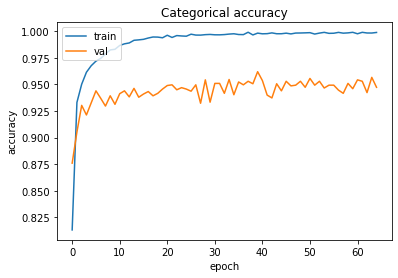

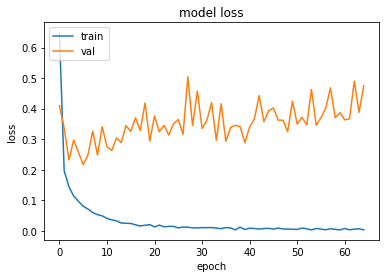

In [8]:
import matplotlib.pyplot as plt

save_dir="output/"+save_name+"_"

# summarize history for categorical accuracy
plt.plot(results.history['sparse_categorical_accuracy'])
plt.plot(results.history['val_sparse_categorical_accuracy'])
plt.title('Categorical accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(save_dir+"Categorical Accuracy", dpi=400)
plt.show()

# summarize history for loss
plt.plot(results.history['loss'])
plt.plot(results.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.savefig(save_dir+"Loss", dpi=400)
plt.show()



--------------------------------------------

# 3) Test the model

In [9]:
#Load TEST file
X,y_test=LoadAndPreprocessDataset.loadBatch(val,batch_size=3000)
#Preprocess TEST
#X_test=LoadAndPreprocessDataset.MFCC_DELTA(X,n_mfcc=40)
#X_test=LoadAndPreprocessDataset.MFCC(X,n_mfcc=40)
X_test=LoadAndPreprocessDataset.melspect(X)
#X_test=X
#Release memory
del(X)

#ADD extra dimension for CNN
import numpy as np
X_test = X_test[..., np.newaxis]

In [10]:
#load best model
from tensorflow.keras.models import load_model
model = load_model('models/'+save_name+'.h5')

# Test the model on test data
import numpy as np
score = model.evaluate(X_test, y_test)
y_pred=np.argmax(model.predict(X_test),1)


#Measure time for every single prediction
"""import time

s=time.time()
y_pred=np.argmax(model.predict(X_test[:500,:,:]),1)
e=time.time()
print("Entire:",e-s)

starts=np.empty((len(X_test),))
ends=np.empty((len(X_test),))
for i in range(len(X_test)):
    a=np.array([X_test[i]])
    starts[i]=time.time()
    a=np.argmax(model.predict(a),1)
    ends[i]=time.time()
average=sum(ends-starts)/len(X_test)
print("Average single prediction time (s):",average)"""

# 1 prediction or a batch of 10 requires the same amount of time
# a batch of 100 prediction requires the double of 1
# a batch of 500 prediction requires the 3 times of 1

3000/3000 [==============================] - 5s 2ms/sample - loss: 0.2980 - sparse_categorical_accuracy: 0.9597


'import time\n\ns=time.time()\ny_pred=np.argmax(model.predict(X_test[:500,:,:]),1)\ne=time.time()\nprint("Entire:",e-s)\n\nstarts=np.empty((len(X_test),))\nends=np.empty((len(X_test),))\nfor i in range(len(X_test)):\n    a=np.array([X_test[i]])\n    starts[i]=time.time()\n    a=np.argmax(model.predict(a),1)\n    ends[i]=time.time()\naverage=sum(ends-starts)/len(X_test)\nprint("Average single prediction time (s):",average)'

# 4) Metrics Summary

Train loss:	 0.003
Train accuracy:	 0.999
Val loss:	 0.475
Val accuracy:	 0.947
Test loss:	 0.298
Test accuracy:	 0.96
Bias:		 0.001
Variance:	 0.052
Precision:	 0.96
Recall:		 0.96
F1:		 0.96


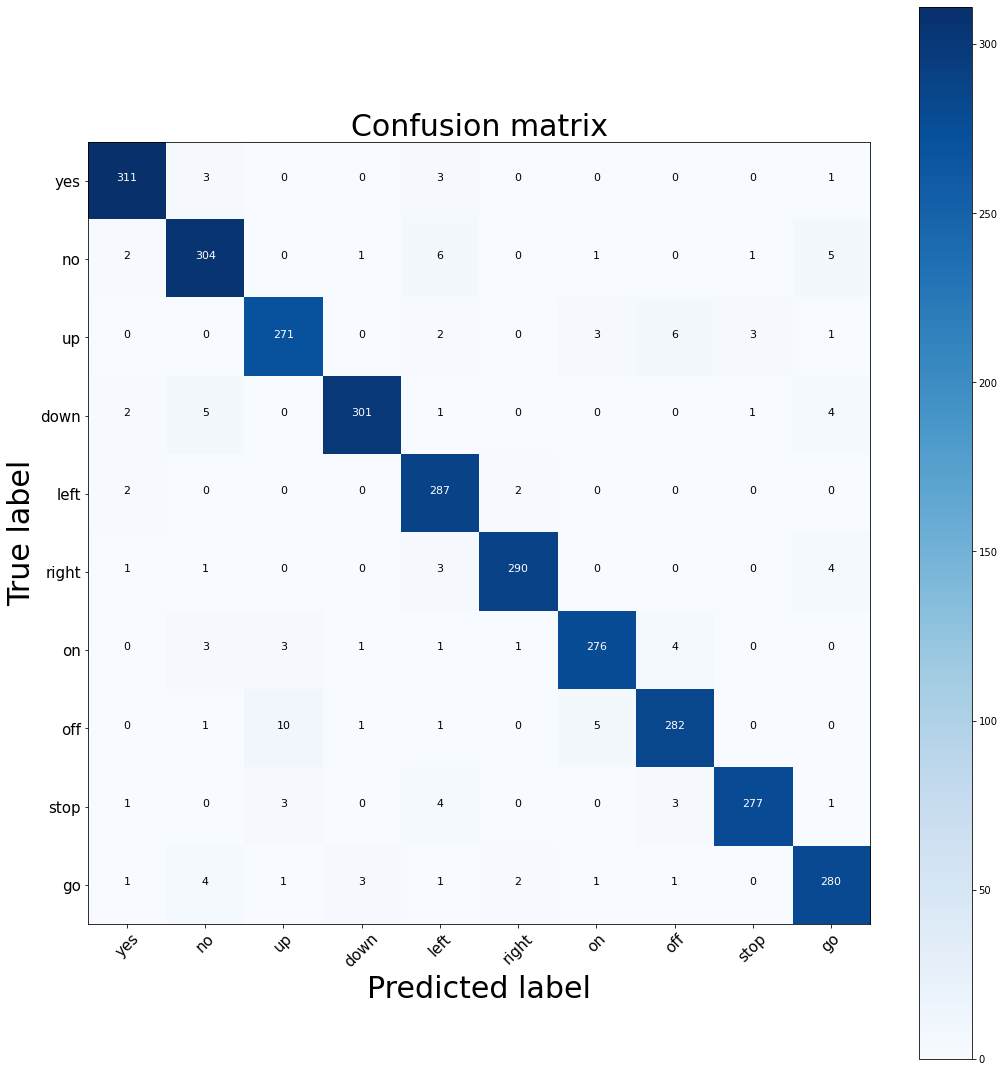

In [11]:
train_loss=results.history.get('loss')[-1]
val_loss=results.history.get('val_loss')[-1]

train_error=1-results.history.get('sparse_categorical_accuracy')[-1]
val_error=1-results.history.get('val_sparse_categorical_accuracy')[-1]

test_loss=score[0]
test_error=1-score[1]

print('Train loss:\t', round(train_loss,3))
print('Train accuracy:\t', round(1-train_error,3))
print('Val loss:\t', round(val_loss,3))
print('Val accuracy:\t', round(1-val_error,3))
print('Test loss:\t', round(test_loss,3))
print('Test accuracy:\t', round(score[1],3))

optimal_error=0.00 #human error

bias=train_error-optimal_error
variance=val_error-train_error
print("Bias:\t\t",round(bias,3))
print("Variance:\t",round(variance,3))


# Precision and Recall(sensitivity/true positive rate)
from sklearn.metrics import precision_score, recall_score
prec=precision_score(y_test, y_pred,average='micro')
rec=recall_score(y_test, y_pred,average='micro')

#F1 - high if both recall and precision are high.
from sklearn.metrics import f1_score
f1=f1_score(y_test, y_pred,average='micro')

print("Precision:\t",round(prec,3))
print("Recall:\t\t",round(rec,3))
print("F1:\t\t",round(f1,3))

# Confusion Matrix
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_test, y_pred)
import audioUtils
audioUtils.plot_confusion_matrix(cm,categories, normalize=False,save_path=save_dir)



# SAVE MODEL SUMMARY and METRICS TO FILE
f = open(save_dir+"Metrics.txt", "a")

stringlist = []
model.summary(print_fn=lambda x: stringlist.append(x))
short_model_summary = "\n".join(stringlist)
f.write(short_model_summary+"\n\n")

f.write('Train loss:\t'+ str(round(train_loss,3))+ "\n")
f.write('Train accuracy:\t'+ str((round(1-train_error,3)))+ "\n")
f.write('Val loss:\t'+ str(round(val_loss,3))+ "\n")
f.write('Val accuracy:\t'+ str((round(1-val_error,3)))+ "\n")
f.write('Test loss:\t'+ str(round(test_loss,3))+ "\n")
f.write('Test accuracy:\t'+ str(round(score[1],3))+ "\n")
f.write("Bias:\t\t"+str(round(bias,3))+ "\n")
f.write("Variance:\t"+str(round(variance,3))+ "\n")
f.write("Precision:\t"+str(round(prec,3))+ "\n")
f.write("Recall:\t\t"+str(round(rec,3))+ "\n")
f.write("F1:\t\t"+str(round(f1,3)))
f.close()